# Homework 3: Retrieval Ensemble

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035


# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [2]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


HOMEWORK_DIR = '/Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework3/'
LOGGER_CONFIG_FILE = HOMEWORK_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.INFO)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[INFO] [2024-12-22T10:01:52.570Z] Logging is configured successfully.


# Dataset'in Yüklenmesi

https://huggingface.co/datasets/mandarjoshi/trivia_qa adresinde bulunan dosyadaki question ve search_results birleştirerek soruları, çıktıyı ise sorunun cevabı answer olarak kullanacağız.

Rastgele 2000 soru ve cevabını seçeceğiz ve bu 2000 örnek üzerinden ödevimizi gerçekleştireceğiz.

Dataset ile ilgili kaynaklar;

- https://huggingface.co/datasets/mandarjoshi/trivia_qa
- https://paperswithcode.com/dataset/triviaqa


Önemli Not: Dataset çok büyük olduğu için training yapılırken kullanılan küçük bir parçası indirilmiştir. İndirilen parçanın linki aşağıda verilmiştir.

[Download 0000.parquet](https://huggingface.co/datasets/mandarjoshi/trivia_qa/resolve/refs%2Fconvert%2Fparquet/rc/train/0000.parquet?download=true)


In [3]:
import pandas as pd

FILE_PATH = HOMEWORK_DIR + '0000.parquet'

# Read the Parquet file into a DataFrame
raw_data_df = pd.read_parquet(FILE_PATH)

logger.info("Columns of the raw dataframe: " + str(raw_data_df.columns))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:53.200Z] Columns of the raw dataframe: Index(['question', 'question_id', 'question_source',
    'entity_pages',        'search_results', 'answer'],       dtype='object')

[INFO] [2024-12-22T10:01:53.201Z] Shape of the dataframe: (5323, 6)


,question,question_id,question_source,entity_pages,search_results,answer
0,Which American-born Sinclair won the Nobel Pri...,tc_1,http://www.triviacountry.com/,"{'doc_source': [], 'filename': [], 'title': []...",{'description': ['The Nobel Prize in Literatur...,"{'aliases': ['(Harry) Sinclair Lewis', 'Harry ..."
1,Where in England was Dame Judi Dench born?,tc_3,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...","{'description': ['Judi Dench, Actress: Skyfall...","{'aliases': ['Park Grove (1895)', 'York UA', '..."
2,In which decade did Billboard magazine first p...,tc_5,http://www.triviacountry.com/,"{'doc_source': [], 'filename': [], 'title': []...",{'description': ['Song chart US Billboard. The...,"{'aliases': ['30's', '30’s', '30s', '30s AD', ..."
3,From which country did Angola achieve independ...,tc_8,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe', 'Search'], '...",{'description': ['Angola; Angola from past to ...,"{'aliases': ['Portogało', 'Republic of Portuga..."
4,Which city does David Soul come from?,tc_9,http://www.triviacountry.com/,"{'doc_source': ['TagMe'], 'filename': ['David_...","{'description': ['David Soul, Actor: Starsky a...","{'aliases': ['Chi-Beria', 'Sayre language acad..."


# Veri Yapısı Hakkında Bilgi

## question

```
Which country is Europe's largest silk producer?
```

## answer

```json
{
  "aliases": [
    "Environment of Italy",
    "Italiën",
    "Subdivisions of Italy",
    "Republic of Italy",
    "ItalY",
    "ISO 3166-1:IT",
    "Etymology of Italy",
    "Italia",
    "Italian Republic",
    "Second Italian Republic",
    "The Italian republic"
  ],
  "normalized_aliases": [
    "second italian republic",
    "itàlia",
    "iso 3166 1 it",
    "italija",
    "etymology of italy",
    "repubblica italiana",
    "itali",
    "italia",
    "republic of italy",
    "italiën",
    "environment of italy"
  ],
  "matched_wiki_entity_name": "",
  "normalized_matched_wiki_entity_name": "",
  "normalized_value": "italy",
  "type": "WikipediaEntity",
  "value": "Italy"
}
```

## search_results

```json
{
  "description": [
    "SILK IN WORLD MARKETS ... , despite the fact that it is now the second largest producer. Some other silk producers are also ... Europe's largest silk ...",
    "Producers and Consumers. ... so silk fabric producers have to make the care of silk easy to compete ... Germany is the largest European market for textiles and ...",
    "... History of Silk Fabric, History of Silk Production ... Andalusia was Europe's main silk-producing ... United States is by far the largest importer of silk ...",
    "... which has wrought tremendous damage in the silk industry in Europe, ... raw silk production is carried on ... The usual wages in the silk-producing countries are ...",
    "Statistics; Silk Products; Search form ... Statistics Global Silk Industry. The major silk producing countries in the world ... India is the world's second largest ..."
  ],
  "filename": ["152/152_666.txt", "46/46_667.txt", "170/170_671.txt"],
  "rank": [2, 3, 4, 6, 7],
  "title": [
    "Silk in World Markets - International Tradeforum",
    "Producers and Consumers - Silk",
    "Raw Silk Production - Old And Sold",
    "Statistics | INTERNATIONAL SERICULTURAL COMMISSION"
  ],
  "url": [
    "http://www.tradeforum.org/Silk-in-World-Markets/",
    "http://globalcommodities-silk.weebly.com/producers-and-consumers.html",
    "http://inserco.org/en/?q=statistics"
  ],
  "search_context": [
    "Silk in World Markets\nSILK IN WORLD MARKETS\n© International Trade Centre, International Trade Forum - Issue 1/1999\nJapan is the world's leading silk consumer.\nSilk has a miniscule percentage of the global textile fibre market-less than 0.2%. This figure, however, is misleading, since the actual trading value of silk and silk products is much more impressive. This is a multibillion dollar trade, with a unit price for raw silk roughly twenty times that of raw cotton. (The precise global value is difficult to assess, since reliable data on finished silk products is lacking in most importing countries.) ",

    "Producers and Consumers - Silk\nSilk\nSignificance to Historical Events\nProducers and Consumers\nSilk has a small percentage in the global textile fiber market, its less than .2%, however the value and products of silk are very impressive. Silk is a multibillion-dollar trade market; the unit price of silk is roughly twenty times the price of raw cotton. The annual turnover of the China National Import and Export Corporation is 2-2.5 billion dollars.",

    "....",
    "....",
    "...."
  ]
}
```


## search_results Boş Değerlerin Kaldırılması

- search_results kolonunda bazı satırlarda değer olmadığı görülmektedir.
- Bunları da dataset üzerinden siliyoruz.


In [4]:
# Uzunlukları anlayabilmek için bir kolon ekleyelim
raw_data_df['search_results_length'] = raw_data_df['search_results'].astype(str).apply(lambda x: len(x))

# Küçükten büyüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='search_results_length', ascending=True)

logger.info("Search results of the first row: " + str(raw_data_df['search_results'].iloc[0]))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.107Z] Search results of the first row: {'description': array([], dtype=object), 'filename':
    array([], dtype=object), 'rank': array([], dtype=int32), 'title': array([], dtype=object), 'url': array([],
    dtype=object), 'search_context': array([], dtype=object)}

[INFO] [2024-12-22T10:01:55.107Z] Shape of the dataframe: (5323, 7)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length
2750,"Which capital city has a name meaning ""I see t...",qz_1396,https://www.quiz-zone.co.uk/,"{'doc_source': ['Search', 'Search'], 'filename...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['Montevideo, Uruguay', 'Montevide...",218
2551,"In April 2003, who became the oldest man to be...",qz_981,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'Search'], 'filename'...","{'description': [], 'filename': [], 'rank': []...",{'aliases': ['Andre Agassi College Preparatory...,218
4898,A TV series starring Bill Maynard in the early...,qz_6697,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Bill_M...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['Gaffer', 'Gaffer (disambiguation...",218
2960,"In 1986, whose song was Christmas number one i...",qz_1809,https://www.quiz-zone.co.uk/,"{'doc_source': ['Search'], 'filename': ['1986_...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['Jackie Wilson's'], 'normalized_a...",218
4896,"A character in the sitcom Friends, or a provis...",qz_6692,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Soap_o...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['Chandler (disambiguation)', 'Cha...",218


Yukarıda görüldüğü gibi search_results kolonunda değer olmayan satırların uzunluğunun aslında 218 olduğu görülmektedir.

- Bu satırları dataset üzerinden silmek için 250 ve aşağısı olan satırları siliyoruz.


In [5]:
raw_data_df = raw_data_df[raw_data_df['search_results_length'] > 250]

logger.info("Search results of the first row: " + str(raw_data_df['search_results'].iloc[0]))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.118Z] Search results of the first row: {'description': array(['"Familiarity breeds contempt
    - and children." ... Breeds, Children, Contempt, Familiarity. BrainyQuote Desktop. BrainyQuote Mobile. Site. Home.
    Authors. Topics. Quote ...'],       dtype=object), 'filename': array(['186/186_229859.txt'], dtype=object), 'rank':
    array([0], dtype=int32), 'title': array(['Familiarity breeds contempt - and children. - Mark Twain ...'],
    dtype=object), 'url': array(['http://www.brainyquote.com/quotes/quotes/m/marktwain107757.html'],       dtype=object),
    'search_context': array(['Familiarity breeds contempt - and children. - Mark Twain - BrainyQuote\nFind on Amazon: Mark
    Twain\nCite this Page: Citation'],       dtype=object)}

[INFO] [2024-12-22T10:01:55.118Z] Shape of the dataframe: (5141, 7)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length
4420,Familiarity breeds contempt - and children.,qz_5411,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['""Familiarity breeds contempt...","{'aliases': ['Mark Twain', 'Thomas Jefferson S...",688
111,What popular drink did a Dutch medical profess...,tc_190,http://www.triviacountry.com/,"{'doc_source': [], 'filename': [], 'title': []...",{'description': ['... What popular drink did a...,"{'aliases': ['Mothers ruin', 'List of gins', '...",712
610,"""Who said, """"A man is only as old as the woman...",tc_1059,http://www.triviacountry.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['""A man's only as old as the ...",{'aliases': ['I don't want to belong to any cl...,713
3860,What is the only US state which borders one ot...,qz_3792,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['U.S._s...",{'description': ['Which USA State borders only...,"{'aliases': ['Religion in Maine', 'Sports in M...",788
3523,Which public service is located near Victoria ...,qz_3025,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['New Scotland Yard, 8-10 Broa...","{'aliases': ['Scotland Yards', 'Scotland Yard ...",793


## answer Kolonu Boş Değerler Kontrolü

- answer kolonunda boş değer var mı kontrol ediyoruz.
- Varsa dataset üzerinden bunları da siliyoruz.


In [6]:
# Uzunlukları anlayabilmek için bir kolon ekleyelim
raw_data_df['answer_length'] = raw_data_df['answer'].astype(str).apply(lambda x: len(x))

# Küçükten büyüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='answer_length', ascending=True)

logger.info("Search results of the first row: " + str(raw_data_df['answer_length'].iloc[0]))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.269Z] Search results of the first row: 238
[INFO] [2024-12-22T10:01:55.269Z] Shape of the dataframe: (5141, 8)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
2256,How many babies did Janet Walton give birth to...,qz_325,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['For many years the Walton si...,"{'aliases': ['six', '6'], 'normalized_aliases'...",189323,238
4624,The Disney Brothers Cartoon Studio was set up ...,qz_5843,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe', 'Search'], '...",{'description': ['The Walt Disney Company (DIS...,"{'aliases': ['Roy'], 'normalized_aliases': ['r...",93750,238
3086,How many pints does a ten gallon hat hold?,qz_2116,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['What's the origin of ""ten-ga...","{'aliases': ['six', '6'], 'normalized_aliases'...",4226,238
2163,What is the maximum no of match points that ca...,qz_151,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['Facts and Figures about ... ...,"{'aliases': ['six', '6'], 'normalized_aliases'...",80340,238
3413,How many blank tiles are there in a game of Sc...,qz_2834,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['... how many letter tiles ar...,"{'aliases': ['2', 'two'], 'normalized_aliases'...",34517,238


## Büyük Boyutlu Örneklerin Silinmesi

search_results kolonunda çok büyük veriler olduğu için kullanılan modeller aşağıdaki hatayı veriyordu.

```
The Kernel crashed while executing code in the current cell or a previous cell.
Please review the code in the cell(s) to identify a possible cause of the failure.
Click <a href='https://aka.ms/vscodeJupyterKernelCrash'>here</a> for more info.
View Jupyter <a href='command:jupyter.viewOutput'>log</a> for further details.
```

- Bu nedenle search_results kolonundaki verilerden uzunluğu en fazla olanlar silinerek işlemlere devam edilecektir.


Yukarıda görüldüğü gibi 1315505 karaketer uzunluklu bile veriler var.

- Bu veriler kernel crash e neden olduğu için silinerek diğer veriler üzerinde işlem yapılacaktır.
- Alt kısımda bu büyük veriler silinecektir.


In [7]:
# büyükten küçüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='answer_length', ascending=False)

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.281Z] Shape of the dataframe: (5141, 8)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
2347,What are the names of the twins in Bart's clas...,qz_504,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['Bartholomew JoJo ""Bart"" Simp...","{'aliases': ['The Winfields', 'Jack Larson (Si...",34055,15881
2563,"In Brookside, which character murdered her fat...",qz_1026,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Brooks...",{'description': ['... she gave Britain its fir...,"{'aliases': ['John Harrison (Brookside)', 'Dia...",299595,6400
914,Which country hosts the Belmont and Preakness ...,tc_1522,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...","{'description': ['... Departures, and a host o...","{'aliases': ['The United States of America', '...",53373,6108
188,Which country did Albert Einstein move to as t...,tc_307,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['Albert Einstein: Albert Eins...,"{'aliases': ['The United States of America', '...",150487,6096
3709,"The Bicycle manufacturers Trek, Giant and Spec...",qz_3481,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe', 'TagMe', 'Ta...",{'description': ['Rick Vosper: Who's Number 1?...,"{'aliases': ['The United States of America', '...",46735,6091


In [8]:
# answer_length i en uzun 1000 satırı silelim
raw_data_df = raw_data_df.iloc[1000:]

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))

logger.info("Answer of the first row: " + str(raw_data_df['answer'].iloc[0]))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.298Z] Shape of the dataframe: (4141, 8)
[INFO] [2024-12-22T10:01:55.300Z] Answer of the first row: {'aliases': array(['Islands of Spain', 'España', 'Reino de
    España', 'Name of Spain',        'Espagna', 'Espańa', 'Reino de Espana', 'Espana',        'Kingdom of the Spains', 'The
    Spanish Society', 'Espainia',        'Mountains of Spain', "Regne d'Espanya", 'The kingdom of Spain',        'SPAIN',
    "Regne d'Espanha", 'Espanya', 'Espainiako Erresuma',        'Etymology of Spain', 'Spane', 'ISO 3166-1:ES', 'Spain',
    'Spanish Kingdom', 'Kingdom of Spain', 'El Reino de España',        'El Reino de Espana'], dtype=object),
    'normalized_aliases': array(['el reino de españa', 'iso 3166 1 es', 'kingdom of spains',        'reino de espana',
    'regne d espanha', 'espagna',        'mountains of spain', 'kingdom of spain', 'name of spain',        'etymology of
    spain', 'regne d espanya', 'spanish kingdom',        'espainiako erresuma', 'reino de españa'

,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
2603,From which country does the dish paella origin...,qz_1107,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Paella...",{'description': ['The History of Paella. ... T...,"{'aliases': ['Islands of Spain', 'España', 'Re...",22368,1164
3422,Bolivia gained independance in 1825 - from whi...,qz_2847,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...","{'description': ['... 1825, Simon Bolivar led ...","{'aliases': ['Islands of Spain', 'España', 'Re...",39135,1164
3597,The Costa del Sol is a region of which country?,qz_3176,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Costa_...",{'description': ['The Costa del Sol is a heave...,"{'aliases': ['Islands of Spain', 'España', 'Re...",20431,1164
1147,Picasso moved to Paris in 1901 but where was h...,tc_1889,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['Life Pablo Ruiz Picasso ... ...,"{'aliases': ['Islands of Spain', 'España', 'Re...",87310,1164
1475,Most of the Three Tenors come from which country?,tc_2353,http://www.triviacountry.com/,"{'doc_source': ['TagMe'], 'filename': ['The_Th...",{'description': ['Discover the three tenors th...,"{'aliases': ['Islands of Spain', 'España', 'Re...",4837,1164


In [9]:
# Apply the lambda function to extract and truncate the first search_context field
# Get the first 500 characters of the search_context field if it is longer than 500 characters

def truncate_answer(answer_row_value):

    all_data = ''
    for value in answer_row_value['value']:
        all_data += value + ' '

    for alias in answer_row_value['aliases']:
        all_data += alias + ' '

    for normalized_alias in answer_row_value['normalized_aliases']:
        all_data += normalized_alias + ' '

    if len(all_data) > 500:
        return all_data[:500]
    else:
        return all_data


raw_data_df['answer'] = raw_data_df['answer'].apply(lambda x: truncate_answer(x))

# Uzunlukları anlayabilmek length kolonunu update edelim
raw_data_df['answer_length'] = raw_data_df['answer'].astype(str).apply(lambda x: len(x))

# büyükten küçüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='answer_length', ascending=False)

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))

logger.info("Answer of the first row: " + str(raw_data_df['answer'].iloc[0]))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.359Z] Shape of the dataframe: (4141, 8)
[INFO] [2024-12-22T10:01:55.359Z] Answer of the first row: S p a i n Islands of Spain España Reino de España Name of
    Spain Espagna Espańa Reino de Espana Espana Kingdom of the Spains The Spanish Society Espainia Mountains of Spain Regne
    d'Espanya The kingdom of Spain SPAIN Regne d'Espanha Espanya Espainiako Erresuma Etymology of Spain Spane ISO 3166-1:ES
    Spain Spanish Kingdom Kingdom of Spain El Reino de España El Reino de Espana el reino de españa iso 3166 1 es kingdom of
    spains reino de espana regne d espanha espagna mountains of spain kingdom of spai



,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
2603,From which country does the dish paella origin...,qz_1107,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Paella...",{'description': ['The History of Paella. ... T...,S p a i n Islands of Spain España Reino de Esp...,22368,500
5064,Anime is film animation originating in which c...,qb_106,http://www.quizballs.com/,"{'doc_source': ['TagMe'], 'filename': ['Anime....",{'description': ['In English-speaking countrie...,J a p a n 日本國 State of Japan Ja-pan Nihon Nipp...,130041,500
998,How is Tenzin Gyatso better known?,tc_1644,http://www.triviacountry.com/,"{'doc_source': ['TagMe'], 'filename': ['14th_D...",{'description': ['The Dalai Lama is both a rel...,T h e D a l i L a m a Dalai-lama Dalli lam...,78106,500
3955,In which area of Germany was he born and raised?,qz_4065,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['German...",{'description': ['My parents were born in Germ...,B a v a r i a Bavarian government Free State o...,77925,500
2190,What is the only gemstone to be composed of on...,qz_201,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'Search'], 'filename'...",{'description': ['April Birthstone Diamonds. M...,D i a m o n d Diamond 4-C's of Diamond Grading...,109709,500


In [10]:
# büyükten küçüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='search_results_length', ascending=False)

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.369Z] Shape of the dataframe: (4141, 8)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
2282,"In 1785, Blanchard and Jeffries became the fir...",qz_378,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Englis...",{'description': ['Crossing the channel: Pionee...,B a l l o o n Baloon Baloons 🎈 Balloon Mylar b...,1315505,238
816,Where did teenager Matthias Rust land his plan...,tc_1362,http://www.triviacountry.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['... Mathias Rust, 19, lands ...",R e d S q u a r e ЯЕD SQЦАЯЕ Red Square (Mos...,1229903,151
4967,Peter Howitt is probably best known for playin...,qz_6857,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Peter_...",{'description': ['Hannah is probably best know...,S l i d i n g D o o r s Sliding Doors Slidin...,1210140,96
3716,"In 2007, contoversy surrounded the naming of a...",qz_3495,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': ['... Capital Community News, ...",A k i t t e n . List of Arduino boards and c...,1011095,290
272,The word anchorman was credited by Sig Michels...,tc_514,http://www.triviacountry.com/,"{'doc_source': ['TagMe'], 'filename': ['CBS_Ne...","{'description': ['Cronkite reported sports, ne...","W a l t e r C r o n k i t e Cronkite, Walter...",824331,481


In [11]:
# # En uzun 1141 satırı silelim
raw_data_df = raw_data_df.iloc[1141:]

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.385Z] Shape of the dataframe: (3000, 8)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
3915,Which British serial killer was played by Rich...,qz_3940,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Richar...",{'description': ['Based on the real-life case ...,J o h n C h r i s t i e John Christie (footb...,66553,195
1393,In what month in 1990 did Iraq invade Kuwait?,tc_2228,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe', 'TagMe'], 'f...",{'description': ['1990 The Invasion of Kuwait;...,A u g u s t Ogos August ㋇ Auggust Augest Aug. ...,66370,79
3952,Which writer and comedian had a family name Ch...,qz_4062,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...",{'description': ['John Cleese (cheese) in MyHe...,J o h n C l e e s e . John Marwood Cleese Ca...,66367,261
232,By what pseudonym is writer Frederick Dannay M...,tc_389,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['SFE : Science Fiction Encycl...,E l l e r y Q u e e n Manfred B. Lee Frederi...,66343,326
1989,What component of CFCs causes destruction of o...,tc_3052,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'TagMe'], 'filename':...",{'description': ['Ozone Destruction. NASA Eart...,C h l o r i n e E925 Dichlorine Chlroine Clori...,66341,500


In [12]:
# Apply the lambda function to extract and truncate the first search_context field
# Get the first 500 characters of the search_context field if it is longer than 500 characters
raw_data_df['search_results'] = raw_data_df['search_results'].apply(
    lambda x: x['search_context'][0][:500] if len(x['search_context'][0]) > 500 else x['search_context'][0]
)

# Uzunlukları anlayabilmek length kolonunu update edelim
raw_data_df['search_results_length'] = raw_data_df['search_results'].astype(str).apply(lambda x: len(x))

# büyükten küçüğe sıralayalım
raw_data_df = raw_data_df.sort_values(by='search_results_length', ascending=False)

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))

logger.info("Search context of the first row: " + str(raw_data_df['search_results'].iloc[0]))
raw_data_df.head()

[INFO] [2024-12-22T10:01:55.402Z] Shape of the dataframe: (3000, 8)
[INFO] [2024-12-22T10:01:55.402Z] Search context of the first row: 10 Rillington Place (1971) - IMDb IMDb 17 January
    2017 4:34 PM, UTC NEWS There was an error trying to load your rating for this title. Some parts of this page won't work
    property. Please reload or try later. X Beta I'm Watching This! Keep track of everything you watch; tell your friends.
    Error Based on the real-life case of the British serial killer John Christie, and what happened to his neighbours Tim
    and Beryl Evans. Director: From $2.99 (SD) on Amazon Video ON DISC a list of 21 titles create



,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
3915,Which British serial killer was played by Rich...,qz_3940,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Richar...",10 Rillington Place (1971) - IMDb\nIMDb\n17 Ja...,J o h n C h r i s t i e John Christie (footb...,500,195
2662,Who did Sue Barker replace as host of the BBC ...,qz_1238,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['A_Ques...",BBC Sport - Question of Sport - The history of...,D a v i d C o l e m a n David Coleman david ...,500,54
4519,Who won an Academy Award for best supporting a...,qz_5605,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['The_Fi...",The Fighter - Awards - IMDb\nMark Wahlberg\nTH...,C h r i s t i a n B a l e Christian Charles ...,500,410
3903,Name the Doctor's robotic companion from the e...,qz_3918,https://www.quiz-zone.co.uk/,"{'doc_source': ['Search'], 'filename': ['Compa...","Doctor Who: The King's Demons review, Doctor W...",K a m e l i o n Kamelion kamelion,500,34
1809,What is studied in the science of cryogenics?,tc_2789,http://www.triviacountry.com/,"{'doc_source': ['TagMe', 'Search'], 'filename'...","Cryogenics - humans, body, used, process, Eart...",V e r y l o w t e m p e r a t u r e Very l...,500,82


## Rastgele 2000 Örneğin Seçilmesi

Rastgele 2000 örnek aşağıdaki şekilde seçilir.

- `random_state` parametresi kullanılarak her çalıştırıldığında aynı örneklerin seçilmesi sağlanır.
- Böylelikle model eğitilirken ve performans ölçümleri yapılırken aynı veri seti üzerinden işlem yapılır.


In [13]:
# TODO: Hızlı embedding çıkarabilmek için örnek sayısını azalttık. Daha sonra 2000 örnek üzerinde çalışacağız.
# number_of_samples = 200
number_of_samples = 2000
# Select a random sample of 2000 questions and answers
sample_df = raw_data_df.sample(n=number_of_samples, random_state=865)

logger.info("Shape of the sampled dataframe: " + str(sample_df.shape))
sample_df.head()

[INFO] [2024-12-22T10:01:55.410Z] Shape of the sampled dataframe: (2000, 8)


,question,question_id,question_source,entity_pages,search_results,answer,search_results_length,answer_length
5268,Which British singer had a lily named after he...,qb_400,http://www.quizballs.com/,"{'doc_source': [], 'filename': [], 'title': []...",Brit Awards 2010: Lady Gaga | Daily Mail Onlin...,L i l y A l l e n Lily Loves Lily Allen (ban...,500,500
630,What sort of Menace was the 1999 Star Wars movie?,tc_1092,http://www.triviacountry.com/,"{'doc_source': ['TagMe'], 'filename': ['Star_W...",Star Wars: Episode I - The Phantom Menace (199...,P h a n t o m Phantom Phantoms (album) The Pha...,500,275
2405,In which children's TV show could you have see...,qz_634,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe'], 'filename': ['Camber...",Children's favourite Windy Miller is drunk on ...,C a m b e r w i c k G r e e n Windy Miller C...,500,92
4797,Who sang the theme song in the film 'From Russ...,qz_6360,https://www.quiz-zone.co.uk/,"{'doc_source': ['TagMe', 'Search'], 'filename'...",From Russia with Love (song) | James Bond Wiki...,M a t t M o n r o Fred Flange Matt Monroe Ma...,500,182
5072,Which English town had the Roman name Dubris?,qb_120,http://www.quizballs.com/,"{'doc_source': ['TagMe'], 'filename': ['Dubris...",#question=Astronomer William Herschel announce...,"D o v e r , K e n t Dover RFC Docks Of Dover...",500,266


## Soru ve Cevapların Oluşturulması


Seçilen 2000 örnek için soru ve cevaplar aşağıdaki şekilde oluşturulur.

- İlgisiz olan kolonlar silinir (question_source, entity_pages)
- question_id kolonu içerisinden sadece soru numarası alınır.
- question kolonu ile search_results kolonu birleştirilerek soru oluşturulur.
- answer kolonu sorunun cevabı olarak kabul edilir.


In [14]:
data_df = pd.DataFrame()

# remove before _ in question_id column qz_5846, tc_434, qz_1686 -> 5846, 434, 1686
data_df['index'] = sample_df['question_id'].str.split('_').str[1].astype(int)

data_df['soru'] = sample_df['question'].astype(str) + " " + sample_df['search_results'].astype(str)

data_df['cevap'] = sample_df['answer'].astype(str)

logger.info("Shape of the sampled dataframe: " + str(data_df.shape))
data_df.head()

# display(data_df)

[INFO] [2024-12-22T10:01:55.420Z] Shape of the sampled dataframe: (2000, 3)


,index,soru,cevap
5268,400,Which British singer had a lily named after he...,L i l y A l l e n Lily Loves Lily Allen (ban...
630,1092,What sort of Menace was the 1999 Star Wars mov...,P h a n t o m Phantom Phantoms (album) The Pha...
2405,634,In which children's TV show could you have see...,C a m b e r w i c k G r e e n Windy Miller C...
4797,6360,Who sang the theme song in the film 'From Russ...,M a t t M o n r o Fred Flange Matt Monroe Ma...
5072,120,Which English town had the Roman name Dubris? ...,"D o v e r , K e n t Dover RFC Docks Of Dover..."


## Temsil Yöntemlerinin Tanımlanması

Aşağıda listesi verilen temsil yöntemleri üzerinde çalışma yapılarak en iyi sonuç veren yöntem gözlemlenecektir. Bu yöntemlerin birleştirilmesi ile oluşan yöntemin başarısı ile kıyaslanacaktır.

- all-MiniLM-L12-v2
- all-mpnet-base-v2
- ytu-ce-cosmos/turkish-colbert
- Multilingual-E5-large-instruct
- dbmdz Turkish BERT model


## all-MiniLM-L12-v2

https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2


In [15]:
from transformers import AutoTokenizer, AutoModel

tokenizer_minilm = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model_minilm = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# all-mpnet-base-v2

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

- It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.


In [16]:
tokenizer_mpnet = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model_mpnet = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

# ytu-ce-cosmos/turkish-colbert

https://huggingface.co/ytu-ce-cosmos/turkish-colbert


In [17]:
tokenizer_cosmos_colbert = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-colbert")
model_cosmos_colbert = AutoModel.from_pretrained("ytu-ce-cosmos/turkish-colbert")

## Multilingual-E5-large-instruct

https://huggingface.co/intfloat/multilingual-e5-large-instruct


In [18]:
tokenizer_multilingual_e5_large = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large-instruct")
model_multilingual_e5_large = AutoModel.from_pretrained("intfloat/multilingual-e5-large-instruct")

# dbmdz Turkish BERT model

https://huggingface.co/dbmdz/bert-base-turkish-cased


In [19]:
tokenizer_dbmdz_turkish_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model_dbmdz_turkish_bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

# Word Embeddings


In [20]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


def mean_pooling(model_output, attention_mask):
    # Mean Pooling - Take attention mask into account for correct averaging

    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def generate_embeddings(texts, tokenizer, model):
    # Function to generate embeddings using a given model and tokenizer
    start_time = time.time()

    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    logger.info("Shape of the model output: " + str(model_output[0].shape))

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    logger.info("Shape of the sentence embeddings: " + str(sentence_embeddings.shape))
    print()

    elapsed_time = time.time() - start_time

    return sentence_embeddings, elapsed_time

In [21]:
minilm_question_embeddings, minilm_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_minilm, model_minilm)

minilm_answer_embeddings, minilm_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_minilm, model_minilm)

[INFO] [2024-12-22T10:02:38.397Z] Shape of the model output: torch.Size([2000, 221, 384])
[INFO] [2024-12-22T10:02:38.507Z] Shape of the sentence embeddings: torch.Size([2000, 384])

[INFO] [2024-12-22T10:03:22.809Z] Shape of the model output: torch.Size([2000, 264, 384])
[INFO] [2024-12-22T10:03:22.925Z] Shape of the sentence embeddings: torch.Size([2000, 384])



In [22]:
mpnet_question_embeddings, mpnet_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_mpnet, model_mpnet)

mpnet_answer_embeddings, mpnet_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_mpnet, model_mpnet)

[INFO] [2024-12-22T10:05:28.898Z] Shape of the model output: torch.Size([2000, 221, 768])
[INFO] [2024-12-22T10:05:29.088Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-22T10:08:50.470Z] Shape of the model output: torch.Size([2000, 264, 768])
[INFO] [2024-12-22T10:08:50.687Z] Shape of the sentence embeddings: torch.Size([2000, 768])



In [23]:
cosmos_colbert_question_embeddings, cosmos_colbert_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_cosmos_colbert, model_cosmos_colbert)

cosmos_colbert_answer_embeddings, cosmos_colbert_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_cosmos_colbert, model_cosmos_colbert)

[INFO] [2024-12-22T10:10:22.218Z] Shape of the model output: torch.Size([2000, 226, 768])
[INFO] [2024-12-22T10:10:22.409Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-22T10:12:04.223Z] Shape of the model output: torch.Size([2000, 250, 768])
[INFO] [2024-12-22T10:12:04.438Z] Shape of the sentence embeddings: torch.Size([2000, 768])



In [24]:
multilingual_e5_large_question_embeddings, multilingual_e5_large_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_multilingual_e5_large, model_multilingual_e5_large)

multilingual_e5_large_answer_embeddings, multilingual_e5_large_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_multilingual_e5_large, model_multilingual_e5_large)

[INFO] [2024-12-22T10:18:10.329Z] Shape of the model output: torch.Size([2000, 259, 1024])
[INFO] [2024-12-22T10:18:10.579Z] Shape of the sentence embeddings: torch.Size([2000, 1024])

[INFO] [2024-12-22T10:24:24.545Z] Shape of the model output: torch.Size([2000, 273, 1024])
[INFO] [2024-12-22T10:24:24.819Z] Shape of the sentence embeddings: torch.Size([2000, 1024])



In [25]:
dbmdz_turkish_bert_question_embeddings, dbmdz_turkish_bert_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_dbmdz_turkish_bert, model_dbmdz_turkish_bert)

dbmdz_turkish_bert_answer_embeddings, dbmdz_turkish_bert_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_dbmdz_turkish_bert, model_dbmdz_turkish_bert)

[INFO] [2024-12-22T10:26:43.336Z] Shape of the model output: torch.Size([2000, 331, 768])
[INFO] [2024-12-22T10:26:43.624Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-22T10:28:39.083Z] Shape of the model output: torch.Size([2000, 282, 768])
[INFO] [2024-12-22T10:28:39.323Z] Shape of the sentence embeddings: torch.Size([2000, 768])



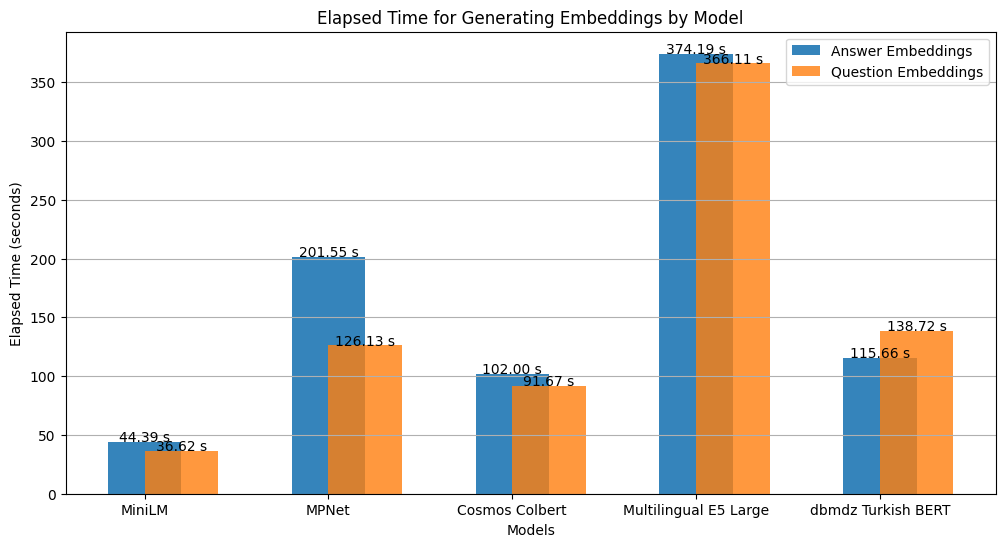

In [26]:
# Plot the elapsed time for each model
import matplotlib.pyplot as plt

models = ['MiniLM', 'MPNet', 'Cosmos Colbert', 'Multilingual E5 Large', 'dbmdz Turkish BERT']
question_times = [minilm_question_time, mpnet_question_time, cosmos_colbert_question_time,
                  multilingual_e5_large_question_time, dbmdz_turkish_bert_question_time]
answer_times = [minilm_answer_time, mpnet_answer_time, cosmos_colbert_answer_time,
                multilingual_e5_large_answer_time, dbmdz_turkish_bert_answer_time]


plt.figure(figsize=(12, 6))
plt.bar(models, answer_times, width=0.4, alpha=0.9, label='Answer Embeddings', align='center')
plt.bar(models, question_times, width=0.4, alpha=0.8, label='Question Embeddings', align='edge')

# Add seconds on top of the bars
for i in range(len(models)):
    plt.text(i + 0.2, question_times[i] + 0.1, f"{question_times[i]:.2f} s", ha='center')
    plt.text(i, answer_times[i] + 0.1, f"{answer_times[i]:.2f} s", ha='center')

plt.xlabel('Models')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Elapsed Time for Generating Embeddings by Model')
plt.legend()
plt.grid(axis='y')
plt.show()

### Modellerin Embedding Süreleri

Yukarıdaki zaman grafiğinden görüldüğü gibi modellerin embedding süreleri aşağıdaki gibidir:

| Model                          | Question (sec.) | Question (min.) | Answer (sec.) | Answer Süresi (min.) |
| ------------------------------ | :-------------: | :-------------: | :-----------: | :------------------: |
| all-MiniLM-L12-v2              |       36        |        0        |      44       |          0           |
| all-mpnet-base-v2              |       126       |        2        |      201      |          3           |
| ytu-ce-cosmos/turkish-colbert  |       91        |        1        |      102      |          1           |
| Multilingual-E5-large-instruct |       366       |        6        |      374      |          6           |
| bert-base-turkish-cased        |       138       |        2        |      115      |          1           |
| **Total**                      |     **757**     |     **12**      |    **836**    |        **13**        |


## Soru ile Cevapların Tümü Arasınada Similarity Değerlerinin Hesabı

Her soru için tüm cevaplar ile similarity (benzerlik) değerleri hesaplanır.

- Bu hesaplama işlemi sonrasında her soru için 2000 adet cevap similarity si değeri elde edilir.
- Bu değerlerden **en büyük olan 5 tanesi (top 5)** seçilir. Diğer değerlerin önemi yoktur.


In [27]:
from sentence_transformers.util import cos_sim
import numpy as np


def get_similarites_and_rankings(question_embeddings, answer_embeddings):

    start_time = time.time()

    data_df_index = 0
    top5_indexes_and_similarities_dictionary = {}

    for question in question_embeddings:
        real_answer_index = data_df['index'].iloc[data_df_index]
        logger.debug("Trying to find the most similar answers to the question at index: " + str(real_answer_index))
        logger.debug("Real Question: " + data_df['soru'].iloc[data_df_index])
        logger.debug("Real Answer: " + data_df['cevap'].iloc[data_df_index])
        data_df_index += 1

        # Compute the similarity between the selected answer and all questions
        similarity_array = []
        for answer in answer_embeddings:
            similarity = cos_sim(answer, question).item()
            similarity_array.append(similarity)

        similarity_array = np.array(similarity_array)
        logger.debug(f"Shape of the similarity array for question {real_answer_index}: {len(similarity_array)}")

        top5_indexes = np.argsort(similarity_array)[-5:][::-1]
        predicted_top5_answer_indexes = data_df['index'].iloc[top5_indexes].values
        top5_similarities = similarity_array[top5_indexes]

        # top5_indexes_and_similarities_dictionary[real_answer_index] = (top5_indexes, top5_similarities)
        top5_indexes_and_similarities_dictionary[real_answer_index] = (predicted_top5_answer_indexes, top5_similarities)

        for i in range(5):
            logger.debug("Top " + str(i + 1) + " answer index: " + str(predicted_top5_answer_indexes[i]) +
                         ", similarity: " + str(top5_similarities[i]))
            # + ", cevap: " + data_df.iloc[top5_indexes[i]]['cevap'])

        # For debugging purposes
        # create top 5 dataframe
        # top5_df = pd.DataFrame(columns=data_df.columns)
        # for i in range(5):
        #     top5_df.loc[i] = data_df.iloc[top5_indexes[i]]
        #
        # display(top5_df)
        # print()
        # print()

    elapsed_time = time.time() - start_time
    logger.info("Elapsed time for finding the most similar answers: " + str(round(elapsed_time, 2)) + " seconds")

    return top5_indexes_and_similarities_dictionary

In [28]:
minilm_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    minilm_question_embeddings, minilm_answer_embeddings)

[INFO] [2024-12-22T10:29:32.235Z] Elapsed time for finding the most similar answers: 51.31 seconds


In [29]:
mpnet_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    mpnet_question_embeddings, mpnet_answer_embeddings)

[INFO] [2024-12-22T10:30:25.075Z] Elapsed time for finding the most similar answers: 52.84 seconds


In [30]:
cosmos_colbert_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    cosmos_colbert_question_embeddings, cosmos_colbert_answer_embeddings)

[INFO] [2024-12-22T10:31:17.835Z] Elapsed time for finding the most similar answers: 52.76 seconds


In [31]:
multilingual_e5_large_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    multilingual_e5_large_question_embeddings, multilingual_e5_large_answer_embeddings)

[INFO] [2024-12-22T10:32:11.713Z] Elapsed time for finding the most similar answers: 53.87 seconds


In [32]:
dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    dbmdz_turkish_bert_question_embeddings, dbmdz_turkish_bert_answer_embeddings)

[INFO] [2024-12-22T10:33:04.263Z] Elapsed time for finding the most similar answers: 52.55 seconds


# Elde Edilen Top 1 ve Top 5 Sonuçlar için Accuracy Hesabı


In [33]:
def calculate_accuracy(top5_indexes_and_similarities_dictionary):
    answer_index = 0
    top1_true_predictions = 0
    top5_true_predictions = 0

    for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():
        answer_index += 1
        if real_answer_index == top5_indexes[0]:
            logger.debug("Question found in top 1!")
            top1_true_predictions += 1
            top5_true_predictions += 1
        elif real_answer_index in top5_indexes:
            logger.debug("Question found in top 5!")
            top5_true_predictions += 1
        else:
            logger.debug("Question not found in top 5!")

    # Calculate accuracy for top 1 and top 5 predictions
    top1_accuracy = (top1_true_predictions / answer_index) * 100
    top5_accuracy = (top5_true_predictions / answer_index) * 100

    logger.info("Top 1 accuracy: " + str(top1_accuracy))
    logger.info("Top 5 accuracy: " + str(top5_accuracy))

    return top1_accuracy, top5_accuracy

In [34]:
accuracy_dictionary = {}
accuracy_dictionary['minilm'] = calculate_accuracy(minilm_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-22T10:33:04.274Z] Top 1 accuracy: 31.358695652173914
[INFO] [2024-12-22T10:33:04.274Z] Top 5 accuracy: 48.09782608695652


In [35]:
accuracy_dictionary['mpnet'] = calculate_accuracy(mpnet_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-22T10:33:04.279Z] Top 1 accuracy: 31.57608695652174
[INFO] [2024-12-22T10:33:04.279Z] Top 5 accuracy: 50.70652173913044


In [36]:
accuracy_dictionary['cosmos_colbert'] = calculate_accuracy(cosmos_colbert_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-22T10:33:04.291Z] Top 1 accuracy: 2.5
[INFO] [2024-12-22T10:33:04.292Z] Top 5 accuracy: 5.380434782608696


In [37]:
accuracy_dictionary['multilingual_e5_large'] = calculate_accuracy(
    multilingual_e5_large_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-22T10:33:04.297Z] Top 1 accuracy: 38.315217391304344
[INFO] [2024-12-22T10:33:04.298Z] Top 5 accuracy: 55.108695652173914


In [38]:
accuracy_dictionary['dbmdz_turkish_bert'] = calculate_accuracy(
    dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-22T10:33:04.303Z] Top 1 accuracy: 0.7065217391304348
[INFO] [2024-12-22T10:33:04.304Z] Top 5 accuracy: 1.576086956521739


Çıkan accuracy değerlerini görselleştirmek için aşağıdaki gibi çizdirelim.


[INFO] [2024-12-22T10:33:04.308Z] Accuracy dictionary: {'minilm': (31.358695652173914, 48.09782608695652), 'mpnet':
    (31.57608695652174, 50.70652173913044), 'cosmos_colbert': (2.5, 5.380434782608696), 'multilingual_e5_large':
    (38.315217391304344, 55.108695652173914), 'dbmdz_turkish_bert': (0.7065217391304348, 1.576086956521739)}



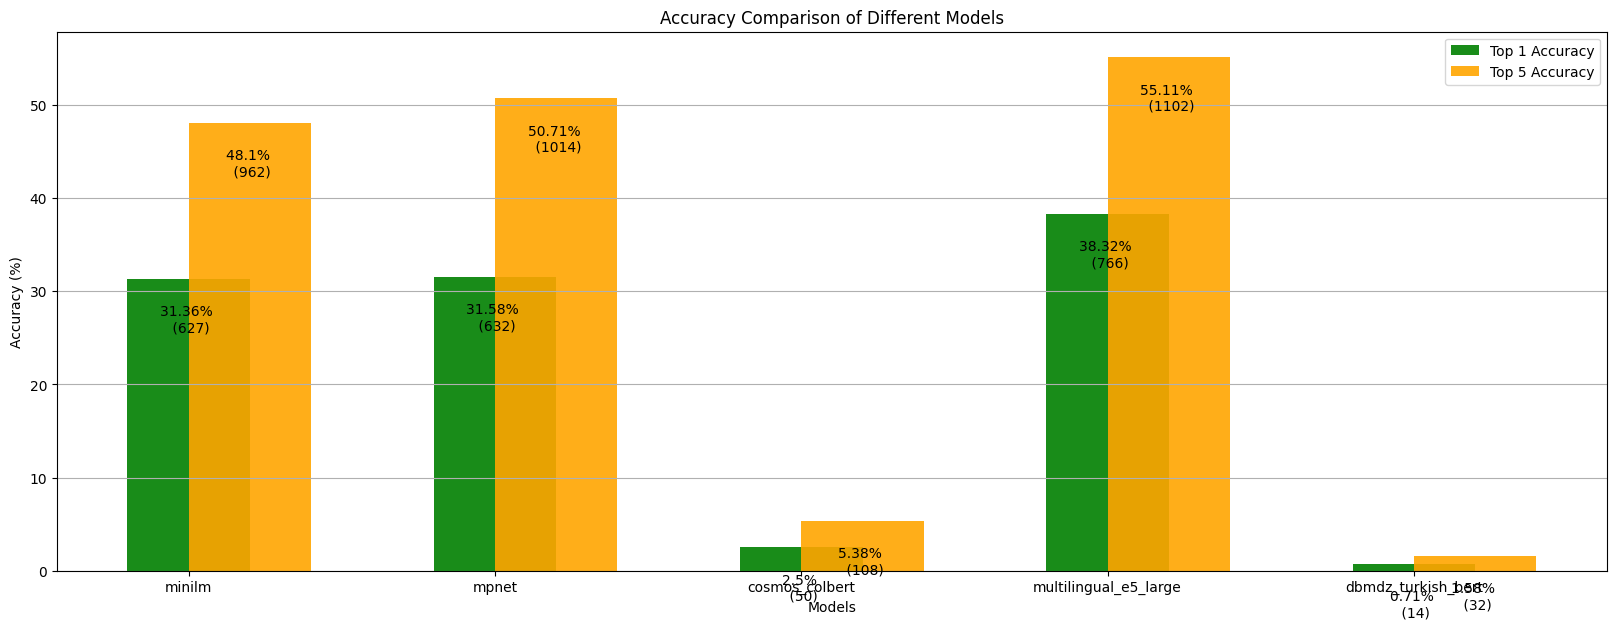

In [39]:
logger.info("Accuracy dictionary: " + str(accuracy_dictionary))


def plot_accuracies(accuracy_dictionary):
    import matplotlib.pyplot as plt

    models = list(accuracy_dictionary.keys())
    top1_accuracies = [accuracy[0] for accuracy in accuracy_dictionary.values()]
    top5_accuracies = [accuracy[1] for accuracy in accuracy_dictionary.values()]

    x = range(len(models))

    plt.figure(figsize=(20, 7))
    plt.bar(x, top1_accuracies, width=0.4, alpha=0.9, label='Top 1 Accuracy', color='green', align='center')
    plt.bar(x, top5_accuracies, width=0.4, alpha=0.9, label='Top 5 Accuracy', color='orange', align='edge')

    # Add percentages on top of the bars
    for i in range(len(models)):
        # round the accuracies to two decimal places
        total_top1_true_predictions = round((number_of_samples * top1_accuracies[i]) / 100)
        total_top5_true_predictions = round((number_of_samples * top5_accuracies[i]) / 100)

        plt.text(x[i], top1_accuracies[i] - 6,
                 str(round(top1_accuracies[i], 2)) + f'% \n ({total_top1_true_predictions})', ha='center', va='bottom')

        plt.text(x[i] + 0.2, top5_accuracies[i] - 6, str(round(top5_accuracies[i], 2)) +
                 f'% \n ({total_top5_true_predictions})', ha='center', va='bottom')

    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison of Different Models')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y')

    plt.show()


plot_accuracies(accuracy_dictionary)

# Temsillerin / Benzerliklerin Birleştirilmesi


Her bir soru için 5 temsil yönteminden (modelden) top1 ve top5 leri al. Benzerlikleri birleştirerek tekil top1 ve top5 üret. (5 -> 1, 25 -> 5)


In [40]:
from collections import Counter


def get_ensemble_method1(indexes, similarities):
    # indexes dizisi içinde en çok tekrar eden index seçilir. Bu indexin similarity değeri de birlikte döndürülür.
    # Testleri ve açıklaması aşağıda verilmiştir.

    # Find the most common index in the array
    most_common_index = Counter(indexes).most_common(1)[0][0]
    most_common_index_count = Counter(indexes).most_common(1)[0][1]

    # Find the indexes with the most common count
    most_common_indexes = [index for index, count in Counter(indexes).items() if count == most_common_index_count]

    # If there is only one index with the most common count, return it
    if len(most_common_indexes) == 1:
        # find all indexes of the most common index and return the max similarity of this indexes
        highest_similarity = 0
        for i in range(len(indexes)):
            if indexes[i] == most_common_indexes[0]:
                if similarities[i] > highest_similarity:
                    highest_similarity = similarities[i]

        return most_common_indexes[0], highest_similarity

    # If there are multiple indexes with the most common count, find the one with the highest similarity
    highest_similarity_index = most_common_indexes[0]
    highest_similarity = 0

    for index in most_common_indexes:
        for i in range(len(indexes)):
            if indexes[i] == index:
                if similarities[i] > highest_similarity:
                    highest_similarity = similarities[i]
                    highest_similarity_index = index

    return highest_similarity_index, highest_similarity


# test için örnek data
# indexes dizisi içinde en çok tekrar eden index seçilir. Bu indexin similarity değeri de birlikte döndürülür.
# Birden fazla similarity olduğu için en büyük olanı seçilir.
top1_predicted_indexes = [1, 2, 3, 4, 3]
top1_similarities = [0.8, 0.9, 0.7, 0.6, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (3, 0.9)

# eşit sayıda index değeri varsa, similarity değerine bakılır. En yüksek similarity değeri olan index seçilir.
top1_predicted_indexes = [1, 2, 3, 2, 3]
top1_similarities = [0.8, 0.5, 0.7, 0.91, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (2, 0.91)

# eşit sayıda index değeri varsa, similarity de eşitse, en küçük index seçilir.
top1_predicted_indexes = [1, 2, 3, 2, 3]
top1_similarities = [0.8, 0.5, 0.7, 0.9, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (2, 0.9)

[INFO] [2024-12-22T10:33:04.409Z] Ensemble method 1 result: (3, 0.9)
[INFO] [2024-12-22T10:33:04.409Z] Ensemble method 1 result: (2, 0.91)
[INFO] [2024-12-22T10:33:04.410Z] Ensemble method 1 result: (2, 0.9)


In [41]:
def get_ensemble_method2(indexes, similarities):
    # indexes dizisi içinde top1 ler arasında en yüksek similarity değerine sahip olan index seçilir.
    # Bu durum similarity değerinin en yüksek olduğu modelin ensemble başarısında ön plana çıkmasını sağlar.
    # Testlerden anlaşıldığı üzere bu "multilingual_e5_large" modelinin ön plana çıkmasını sağlamaktadır.
    # Testleri ve açıklaması aşağıda verilmiştir.

    highest_similarity_index = np.argmax(similarities)
    highest_similarity = similarities[highest_similarity_index]
    highest_similarity_index = indexes[highest_similarity_index]

    return highest_similarity_index, highest_similarity


# test için örnek data
# Index in kaç kere tekrar ettiği önemli değil. Top1 ler arasında en yüksek similarity değerine sahip olan index seçilir.
top1_predicted_indexes = [5, 5, 3, 4, 2]
top1_similarities = [0.8, 0.9, 0.7, 0.6, 0.91]
most_greater_similarity_index_and_similarity = get_ensemble_method2(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 2 result: " + str(most_greater_similarity_index_and_similarity))
assert most_greater_similarity_index_and_similarity == (2, 0.91)

# eşit similarity değerine sahip indexler varsa, en küçük index seçilir.
top1_predicted_indexes = [5, 5, 3, 4, 2]
top1_similarities = [0.8, 0.9, 0.7, 0.9, 0.9]
most_greater_similarity_index_and_similarity = get_ensemble_method2(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 3 result: " + str(most_greater_similarity_index_and_similarity))
assert most_greater_similarity_index_and_similarity == (5, 0.9)

[INFO] [2024-12-22T10:33:04.415Z] Ensemble method 2 result: (2, 0.91)
[INFO] [2024-12-22T10:33:04.415Z] Ensemble method 3 result: (5, 0.9)


In [42]:
def get_ensemble_method3(top25_indexes, top25_similarities):
    # indexes dizisi içinde top 25 index bulunur. Bunlardan en çok tekrar eden 5 index seçilerek top5 index oluşturulur.
    # Bu top5 indexler arasından da eşit sayıda olanlar varsa, en yüksek similarity değerine sahip olan index seçilir.
    # Testleri ve açıklaması aşağıda verilmiştir.

    selected_top5_indexes = []
    selected_top5_similarities = []

    # Find the most common index in the array
    top5_indexes = Counter(top25_indexes).most_common(5)

    for index, _ in top5_indexes:
        # find all indexes of the most common index and return the max similarity of this indexes
        highest_similarity = 0
        for i in range(len(top25_indexes)):
            if top25_indexes[i] == index:
                if top25_similarities[i] > highest_similarity:
                    highest_similarity = top25_similarities[i]

        selected_top5_indexes.append(index)
        selected_top5_similarities.append(highest_similarity)

    return selected_top5_indexes, selected_top5_similarities


# test için örnek data
# indexes dizisi içinde top 25 index bulunur. Bunlardan en çok tekrar eden 5 index seçilerek top5 index oluşturulur.
# indexlere ait similarity değerlerinden en yüksek olanlar seçilir.
top25_predicted_indexes = [5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4]
top25_similarities = [0.8, 0.9, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.91,
                      0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.99, 0.8, 0.9, 0.7, 0.6]
selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_predicted_indexes, top25_similarities)
logger.info("Ensemble method 3 result, selected top 5 indexes: " + str(selected_top5_indexes))
logger.info("Ensemble method 3 result, selected top 5 similarities: " + str(selected_top5_similarities))
assert selected_top5_indexes == [9, 8, 7, 6, 5]
assert selected_top5_similarities == [0.99, 0.95, 0.9, 0.91, 0.9]

# eşit sayıda index değeri varsa, similarity değerine bakılır. En yüksek similarity değeri olan index seçilir.

top25_predicted_indexes = [5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4]
top25_similarities = [0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.91,
                      0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.99, 0.8, 0.9, 0.7, 0.6]
selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_predicted_indexes, top25_similarities)
logger.info("Ensemble method 3 result, selected top 5 indexes: " + str(selected_top5_indexes))
logger.info("Ensemble method 3 result, selected top 5 similarities: " + str(selected_top5_similarities))
assert selected_top5_indexes == [9, 8, 7, 5, 6]
# assert selected_top5_similarities == [0.99, 0.95, 0.9, 0.95, 0.7]

[INFO] [2024-12-22T10:33:04.421Z] Ensemble method 3 result, selected top 5 indexes: [9, 8, 7, 6, 5]
[INFO] [2024-12-22T10:33:04.421Z] Ensemble method 3 result, selected top 5 similarities: [0.99, 0.95, 0.9, 0.91, 0.9]
[INFO] [2024-12-22T10:33:04.422Z] Ensemble method 3 result, selected top 5 indexes: [9, 8, 7, 5, 6]
[INFO] [2024-12-22T10:33:04.422Z] Ensemble method 3 result, selected top 5 similarities: [0.91, 0.95, 0.91, 0.95, 0.7]


In [43]:
def get_ensemble_top5_indexes_and_similarities(top5_indexes_and_similarities_dictionaries, ensemble_method):
    combined_top5_indexes_and_similarities_dictionary = {}

    data_dictionary = {}

    # concatenate all top5 indexes and similarities. Result will be 25 indexes and similarities
    for model_name, (top5_indexes_and_similarities_dictionary) in top5_indexes_and_similarities_dictionaries.items():
        data_dictionary[model_name] = {}

        for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():

            logger.debug(f"Model: {model_name}, Question: {real_answer_index}")
            logger.debug(f"Indexes: {top5_indexes}")
            logger.debug(f"Similarities: {top5_similarities}")
            logger.debug("")

            if real_answer_index not in combined_top5_indexes_and_similarities_dictionary:
                combined_top5_indexes_and_similarities_dictionary[real_answer_index] = (
                    [[] for _ in range(5)], [[] for _ in range(5)])

            for i in range(5):
                combined_top5_indexes_and_similarities_dictionary[real_answer_index][0][i].append(top5_indexes[i])
                combined_top5_indexes_and_similarities_dictionary[real_answer_index][1][i].append(top5_similarities[i])

    ensemble_top5_indexes_and_similarities = {}
    for real_answer_index, (indexes, similarities) in combined_top5_indexes_and_similarities_dictionary.items():

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Indexes: {indexes}, Similarities: {similarities}")

        selected_top5_indexes = []
        selected_top5_similarities = []

        for i in range(5):
            # Use get_ensemble_method1 to get the final top 5 combined indexes and similarities

            if ensemble_method == "method_1":
                selected_index, selected_similarity = get_ensemble_method1(indexes[i], similarities[i])
            elif ensemble_method == "method_2":
                selected_index, selected_similarity = get_ensemble_method2(indexes[i], similarities[i])
            else:
                raise ValueError("Invalid ensemble method: " + ensemble_method)

            selected_top5_indexes.append(selected_index)
            selected_top5_similarities.append(selected_similarity)

        ensemble_top5_indexes_and_similarities[real_answer_index] = (selected_top5_indexes, selected_top5_similarities)

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Ensemble: {ensemble_top5_indexes_and_similarities[real_answer_index]}")

    return ensemble_top5_indexes_and_similarities

In [44]:
# Örnek Çalışması aşağıdaki gibi:
#
# [INFO] [2024-12-18T22:46:14.989Z] Model: minilm, Question: 19512
# [INFO] [2024-12-18T22:46:14.990Z] Indexes: [31132 47052 21135 25299 15663]
# [INFO] [2024-12-18T22:46:14.991Z] Similarities: [0.65630591 0.59570324 0.5854063  0.57706159 0.55521119]
# [INFO] [2024-12-18T22:46:14.991Z]
#
# [INFO] [2024-12-18T22:46:15.083Z] Model: mpnet, Question: 19512
# [INFO] [2024-12-18T22:46:15.084Z] Indexes: [31132  6260 33525 25299 31457]
# [INFO] [2024-12-18T22:46:15.084Z] Similarities: [0.7082091  0.65570903 0.65200913 0.64118457 0.6273461 ]
# [INFO] [2024-12-18T22:46:15.084Z]
#
# [INFO] [2024-12-18T22:46:15.141Z] Model: cosmos_colbert, Question: 19512
# [INFO] [2024-12-18T22:46:15.142Z] Indexes: [31132 47052 19512 25299 48133]
# [INFO] [2024-12-18T22:46:15.142Z] Similarities: [0.61857104 0.60996813 0.60277951 0.60016912 0.59341037]
# [INFO] [2024-12-18T22:46:15.142Z]
#
# [INFO] [2024-12-18T22:46:15.201Z] Model: multilingual_e5_large, Question: 19512
# [INFO] [2024-12-18T22:46:15.201Z] Indexes: [19512 27183 23498  7324 33933]
# [INFO] [2024-12-18T22:46:15.201Z] Similarities: [0.87906605 0.87463862 0.8411001  0.84046221 0.8331328 ]
# [INFO] [2024-12-18T22:46:15.202Z]
#
# [INFO] [2024-12-18T22:46:15.333Z] Model: dbmdz_turkish_bert, Question: 19512
# [INFO] [2024-12-18T22:46:15.333Z] Indexes: [31132 15393 27183  6260  4639]
# [INFO] [2024-12-18T22:46:15.334Z] Similarities: [0.83515263 0.83198321 0.81642026 0.81306916 0.80721843]
# [INFO] [2024-12-18T22:46:15.334Z]
#
# [INFO] [2024-12-18T22:46:15.421Z] Question: 19512
# [INFO] [2024-12-18T22:46:15.421Z] Indexes: [[31132, 31132, 31132, 19512, 31132], [47052, 6260, 47052, 27183, 15393],
#     [21135, 33525, 19512, 23498, 27183], [25299, 25299, 25299, 7324, 6260], [15663, 31457, 48133, 33933, 4639]],
#     Similarities: [[0.6563059091567993, 0.7082090973854065, 0.6185710430145264, 0.8790660500526428, 0.8351526260375977],
#     [0.5957032442092896, 0.6557090282440186, 0.6099681258201599, 0.8746386170387268, 0.831983208656311],
#     [0.5854063034057617, 0.652009129524231, 0.6027795076370239, 0.8411000967025757, 0.8164202570915222],
#     [0.5770615935325623, 0.6411845684051514, 0.6001691222190857, 0.8404622077941895, 0.8130691647529602],
#     [0.5552111864089966, 0.6273460984230042, 0.5934103727340698, 0.833132803440094, 0.8072184324264526]]
#
# [INFO] [2024-12-18T22:46:15.421Z] Question: 19512
# [INFO] [2024-12-18T22:46:15.422Z] Ensemble: ([31132, 47052, 23498, 25299, 33933],
#                     [0.8351526260375977, 0.6099681258201599, 0.8411000967025757, 0.6411845684051514, 0.833132803440094])

In [45]:
def get_ensemble_top5_indexes_and_similarities_2(top5_indexes_and_similarities_dictionaries, ensemble_method):

    combined_top25_indexes_and_similarities_dictionary = {}
    ensemble_top5_indexes_and_similarities_dictionary = {}

    top25_indexes = []
    top25_similarities = []

    if ensemble_method != "method_3":
        raise ValueError("Invalid ensemble method: " + ensemble_method)

    # concatenate all top5 indexes and similarities. Result will be 25 indexes and similarities
    for model_name, (top5_indexes_and_similarities_dictionary) in top5_indexes_and_similarities_dictionaries.items():
        for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():

            logger.debug(f"Model: {model_name}, Question: {real_answer_index}")
            logger.debug(f"Indexes: {top5_indexes}")
            logger.debug(f"Similarities: {top5_similarities}")
            logger.debug("")

            if real_answer_index not in combined_top25_indexes_and_similarities_dictionary:
                combined_top25_indexes_and_similarities_dictionary[real_answer_index] = ([], [])

            combined_top25_indexes_and_similarities_dictionary[real_answer_index][0].extend(top5_indexes)
            combined_top25_indexes_and_similarities_dictionary[real_answer_index][1].extend(top5_similarities)

    for real_answer_index, (top25_indexes, top25_similarities) in combined_top25_indexes_and_similarities_dictionary.items():
        selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_indexes, top25_similarities)
        ensemble_top5_indexes_and_similarities_dictionary[real_answer_index] = (
            selected_top5_indexes, selected_top5_similarities)

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Ensemble: {ensemble_top5_indexes_and_similarities_dictionary[real_answer_index]}")

    return ensemble_top5_indexes_and_similarities_dictionary

In [ ]:
top5_indexes_and_similarities_dictionaries = {'minilm': minilm_top5_indexes_and_similarities_dictionary,
                                              'mpnet': mpnet_top5_indexes_and_similarities_dictionary,
                                              'cosmos_colbert': cosmos_colbert_top5_indexes_and_similarities_dictionary,
                                              'multilingual_e5_large': multilingual_e5_large_top5_indexes_and_similarities_dictionary,
                                              'dbmdz_turkish_bert': dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary
                                              }

ensemble_top5_indexes_and_similarities_dictionary_method_1 = get_ensemble_top5_indexes_and_similarities(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_1")

In [ ]:
ensemble_top5_indexes_and_similarities_dictionary_method_2 = get_ensemble_top5_indexes_and_similarities(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_2")

In [ ]:
ensemble_top5_indexes_and_similarities_dictionary_method_3 = get_ensemble_top5_indexes_and_similarities_2(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_3")

[INFO] [2024-12-22T10:33:39.780Z] Top 1 accuracy: 32.33695652173913
[INFO] [2024-12-22T10:33:39.780Z] Top 5 accuracy: 38.42391304347826
[INFO] [2024-12-22T10:33:39.781Z] Top 1 accuracy: 1.4673913043478262
[INFO] [2024-12-22T10:33:39.781Z] Top 5 accuracy: 2.282608695652174
[INFO] [2024-12-22T10:33:39.782Z] Top 1 accuracy: 34.02173913043478
[INFO] [2024-12-22T10:33:39.782Z] Top 5 accuracy: 52.60869565217391


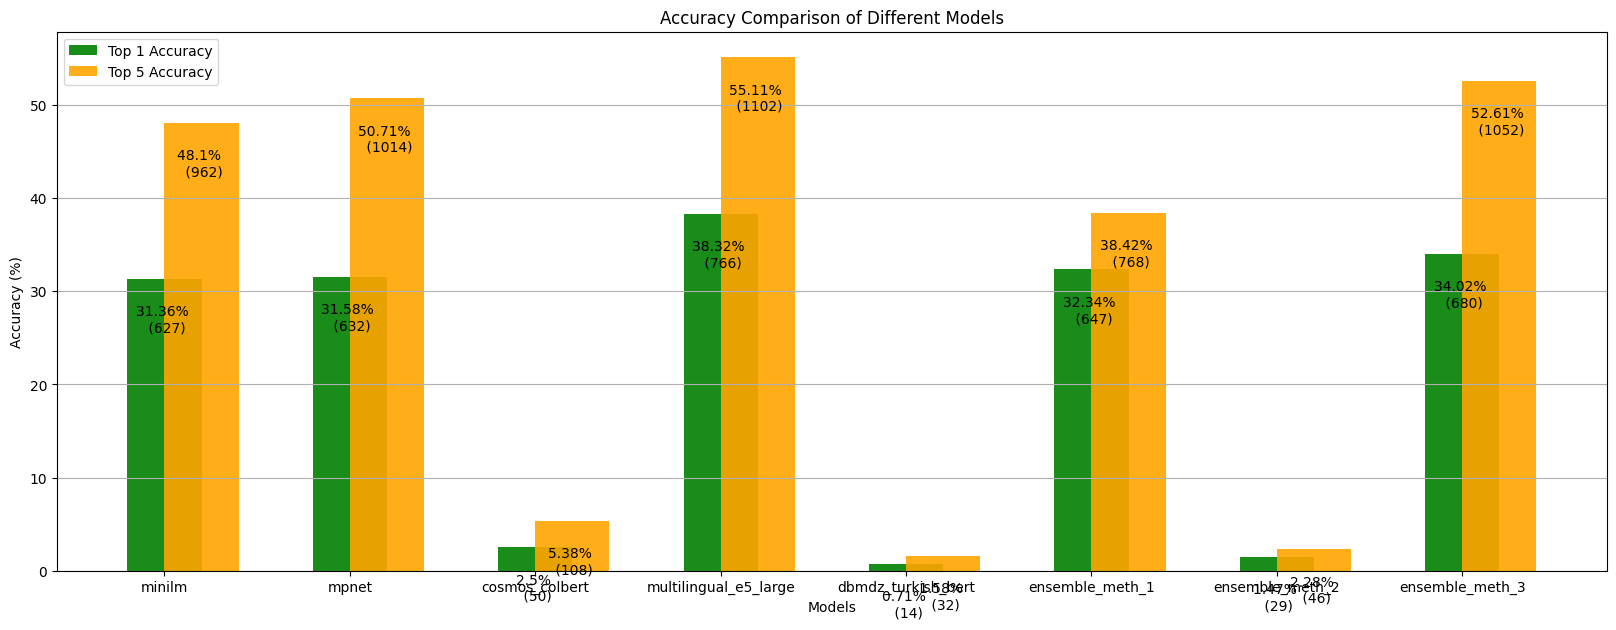

In [49]:
accuracy_dictionary['ensemble_meth_1'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_1)
accuracy_dictionary['ensemble_meth_2'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_2)
accuracy_dictionary['ensemble_meth_3'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_3)
plot_accuracies(accuracy_dictionary)

# Sonuçlar

- multilingual-e5-large-instruct modeli en iyi sonucu vermiştir.
- Diğer modellerin başarı sırasına göre dizilimi aşağıdaki gibi:
  - all-mpnet-base-v2
  - all-MiniLM-L12-v2
  - ytu-ce-cosmos/turkish-colbert
  - bert-base-turkish-cased

* Ensemble başarılarının en iyi olduğu model multilingual-e5-large-instruct dan daha düşük çıktığı görülmüştür.
  - Bunun nedeninin diğer modellerin ortalama başarısının düşük olması nedeniyle kollektif başarıyı düşürmesine bağlayabiliriz.
  - Ensemble kararı üzerinde diğer modellerin verdiği ortak kararında etkisi olduğu için ortak karar başarısı düşük çıkmıştır.

# Feature Work

- Yukarıda sunulan sonuçların gerçekten doğruluğunun anlaşılabilmesi için en başarılı olan modelin çıkarılarak diğer 4 modelin başarısı ölçümlenebilirdi.
- Bu durumda kollektif başarının ne olduğuna bakarsak aslında yukarıda sunduğumuz hipotezin doğru olup olmadığına karar verebiliriz.
- Yukarıdaki denemeler modellerin embedding leri çıkarma süresinin 2000 örnek için uzun sürmesi nedeniyle yapılamamıştır.


# Referanslar

- [IBM Technology - What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
- [Advanced RAG: Ensemble Retrieval](https://www.youtube.com/watch?v=s2i4zeWjUtM)
- [Advanced RAG 01 - Self Querying Retrieval](https://www.youtube.com/watch?v=f4LeWlt3T8Y)
- https://huggingface.co/datasets/merve/turkish_instructions
- https://huggingface.co/datasets/mandarjoshi/trivia_qa
- [all-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2)
- [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
- [ytu-ce-cosmos/turkish-colbert](https://huggingface.co/ytu-ce-cosmos/turkish-colbert)
- [Multilingual-E5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct)
- [dbmdz Turkish BERT model](https://huggingface.co/dbmdz/bert-base-turkish-cased)
